# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В данных имеются следующие входные признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

А также целевой признак:
- Price — цена (евро)

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__[0] == '0':
    !pip install scikit-learn -U # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.1'

In [2]:
#!pip install -U Pillow # Для решения ошибки с профайлером

In [3]:
import pandas as pd
import numpy as np

try:
    from ydata_profiling import ProfileReport
except:
    !pip install -U Pillow # Для решения ошибки с профайлером
    !pip install -U ydata-profiling
    from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
RANDOM_STATE = 42

## Подготовка данных

Для начала проведём EDA - разведочный анализ данных. Взглянем на них под всеми возможными углами, посмотрим на имеющиеся аномалии, корреляцию признаков и проверим общее качество имеющихся данных.

In [5]:
try:
    ds = pd.read_csv('/datasets/autos.csv')
except:
    ds = pd.read_csv('datasets/autos.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
#ProfileReport(ds)

Пройдёмся по порядку. Профайлер любезно сгруппировал для нас все проблемы данных, на которые нам стоит взглянуть.

`NumberOfPictures` - константа, содержащая исключительно нули. Судя по всему, признак сломан. Сомневаюсь, что за 350 тысяч выставленных на продажу автомобилей не было сделано ни одного фото. От него можно избавиться

In [7]:
ds = ds.drop('NumberOfPictures', axis=1)
ds.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

4 полных дубликата. Несмотря на то, что в данных нету полностью уникальных признаков, которые могли-бы исключить то, что это попросту похожие записи, в рамках обучения дубликаты нам будут только мешать. Удалим их.

In [8]:
ds = ds.drop_duplicates()
ds.duplicated().sum()

0

Аномальные значения года регистрации. От 1000 до 9999

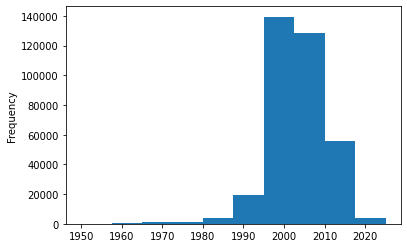

In [9]:
ds['RegistrationYear'].plot(kind='hist', range=(1950, 2025));

Основная масса значений находится в промежутке от 1950 до 2025, её мы и возьмём.

In [10]:
ds = ds[ds['RegistrationYear'].isin(range(1950, 2025))]
print('max:', ds['RegistrationYear'].max())
print('min:', ds['RegistrationYear'].min())

max: 2019
min: 1950


`Power`, значение мощности в лошадиных силах, содержит аномально высокие значения. Исключим все записи со значениями выше, чем среднее плюс 3 стандартных отклонения.

In [11]:
ds = ds[ds['Power']<=ds['Power'].mean()+np.std(ds['Power'])*3]
ds['Power'].max()

678

Оно-же содержит огромное количество нулей, около 11%. Однако, учитывая специфику магазина, можно предположить, что таким образом отображаются машины не на ходу. Оставим эти значения.

Все даты сохранились в формате строк.

In [12]:
for i in ['DateCrawled', 'DateCreated', 'LastSeen']:
    ds[i] = pd.to_datetime(ds[i], format='%Y-%m-%d %H:%M:%S')
    print(np.dtype(ds[i]))

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [13]:
ds = ds.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

## Обучение моделей

Для начала распределим данные. Их у нас много, поэтому на тестовую выборку можем не жалеть, возьмём 20% от генеральной совокупности и отложим до готовности. Оставшиеся 80% будут для нас одновременно тренировочными и валидационными данными.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    ds.drop('Price', axis=1), 
    ds['Price'], 
    test_size=0.2, 
    random_state=RANDOM_STATE)

Теперь нам нужно распределить признаки на численные и категориальные, это понадобится при составлении пайплайнов.

In [15]:
ohe_columns = X_train.select_dtypes(include='object').columns
num_columns = X_train.select_dtypes(include='number').columns
print(ohe_columns, num_columns)

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], dtype='object') Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode'],
      dtype='object')


А вот и пайплайны. Создадим два для препроцессинга. Один из них будет обрабатывать категории при помощи OneHotEncoder, второй будет скейлить числа при помощи MinMaxScaler. Оба заполнят пропуски перед началом работы.

In [16]:
ohe_pipe = Pipeline([
    ('impute_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])
num_pipe = Pipeline([
    ('impute_num', KNNImputer(n_neighbors=15)),
    ('scaler', MinMaxScaler())
])

Чтобы модель поняла куда какие признаки направлять - объединим пайплайны в ColumnsTransformer, и назначим соответствующие столбцы для каждого пайплайна препроцессинга.

In [17]:
data_preprocessor = ColumnTransformer([
    ('ohe_encode', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

С препроцессингом закончили, дальше составим пайплайны непосредственно для моделей. За основу мы возьмём три модели - лёгкий градиентный бустинг, линейную регрессию и регрессор дерева решений

In [18]:
gbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])
linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor())
])

Теперь создадим сетки параметров для дерева решений и градиентного бустинга. У линейной регрессии нету гиперпараметров, которые мы могли-бы подобрать для улучшения качества, поэтому она обойдётся обычной кросс-валидацией. Сразу-же создадим объекты RandomizedSearchCV. Данных много, модели будут обучаться долго, поэтому придётся довольствоваться малым количеством блоков при кросс-валидации и малым количеством итераций. 

In [19]:
tree_params = {
    'model__max_depth':range(3, 15),
    'model__min_samples_leaf':range(1, 10),
    'model__min_samples_split':range(2, 10)
}
gbm_params = {
    'model__boosting_type':['gbdt', 'dart'],
    'model__max_depth':range(5, 20)
}

gbm_cval = RandomizedSearchCV(gbm, param_distributions=gbm_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=2, n_iter=4, random_state=RANDOM_STATE)
tree_cval = RandomizedSearchCV(tree, param_distributions=tree_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=2, n_iter=4, random_state=RANDOM_STATE)

А теперь последовательно запустим обучение моделей. При проверке качества мы будем использовать метрику RMSE - корень среднего квадрата ошибок. Чем ниже значение метрики - тем лучше работает наша модель.

In [20]:
%%time
gbm_cval.fit(X_train, y_train)
abs(gbm_cval.best_score_)

CPU times: user 3min 50s, sys: 9.44 s, total: 4min
Wall time: 4min 2s


2090.737558584314

Значение неплохое, значительно ниже 2500, где находится наш критерий успеха. Однако обучение заняло немало времени.

In [21]:
%%time
abs(cross_val_score(linear, X_train, y_train, scoring='neg_root_mean_squared_error', cv=4, n_jobs=-1).max())

CPU times: user 1min 5s, sys: 24.1 s, total: 1min 29s
Wall time: 1min 29s


2831.5017572969177

Крайне плохой показатель. Судя по всему линейная регрессия нам не подойдёт, но проверить было не лишним.

In [22]:
%%time
tree_cval.fit(X_train, y_train)
abs(tree_cval.best_score_)

CPU times: user 41.1 s, sys: 8.79 s, total: 49.9 s
Wall time: 50 s


2044.879134967468

## Анализ моделей

In [27]:
%%time
gbm_cval.best_estimator_.fit(X_train, y_train)
root_mean_squared_error(y_test, gbm_cval.best_estimator_.predict(X_test))

CPU times: user 48.3 s, sys: 1.48 s, total: 49.8 s
Wall time: 50 s


2107.80786634613

In [28]:
%%time
tree_cval.best_estimator_.fit(X_train, y_train)
root_mean_squared_error(y_test, tree_cval.best_estimator_.predict(X_test))

CPU times: user 10.3 s, sys: 1.17 s, total: 11.5 s
Wall time: 11.6 s


2003.9659094251035

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей